# Strava to Jupyter: Playbook

This notebook offers some tools to play around with your Strava data in Python.
Some hacks are used to get Strava API authentication running.


## Getting started: Step 1/5
If you do not already have a Strava API Application, create one at <https://www.strava.com/settings/api>. You can fill all fields to your liking, but the "Authorization Callback Domain" must be "mybinder.org", otherwise the authentication flow will not work.

Documentation about the Strava API can be found [here](https://developers.strava.com/).

## Getting started: Step 2/5
Now run the cell below and enter your Strava Client ID and secret at the prompts.

In [6]:
import getpass
from datetime import timedelta
from urllib.parse import parse_qs, urlparse

import pandas as pd
from IPython.display import display, HTML, Markdown
from sweat.metrics.core import mean_max
from sweat.pdm import w_prime_balance

from tools import Client

%matplotlib inline


STRAVA_CLIENT_ID = input('Enter your Strava Client ID: ')
STRAVA_CLIENT_SECRET = getpass.getpass('Enter your Strava Client Secret: ')


HTML(
    '''
    <script type="text/javascript">
        IPython.notebook.kernel.execute("notebook_url = '" + window.location + "'")
    </script>
    '''
)

Enter your Strava Client ID: 6218
Enter your Strava Client Secret: ········


## Getting started: Step 3/5
Now execute the cell below and click the generated url. The variable `notebook_url` is generated by the magic HTML-code in the previous cell.

**Warning**: This will direct you away from this page and directly back afterwards but you will need to scroll down a bit to get back to the next step.

In [7]:
client = Client()
url = client.authorization_url(
    client_id=STRAVA_CLIENT_ID,
    redirect_uri=f'{notebook_url}'
)

display(Markdown(f'<{url}>'))

<https://www.strava.com/oauth/authorize?client_id=6218&redirect_uri=http%3A%2F%2Flocalhost%3A8889%2Fnotebooks%2Fplaybook.ipynb&approval_prompt=auto&response_type=code&scope=read%2Cactivity%3Aread>

## Getting started: Step 4/5
Subsequently execute the following cell. This (again) uses some HTML magic to fetch a code that Strava inserted into the callback (redirect) url.

In [8]:
HTML('''
    <script type="text/javascript">
        IPython.notebook.kernel.execute("redirect_url = '" + window.location + "'")
    </script>''')

## Getting started: Step 5/5
And finally execute the next cell to exchange the code Strava sent you for a proper authentication token that we can use to get you activity data.

In [9]:
query_string = urlparse(redirect_url).query
query_params = parse_qs(query_string, keep_blank_values=True)

client.exchange_code_for_token(
    client_id=STRAVA_CLIENT_ID,
    client_secret=STRAVA_CLIENT_SECRET,
    code=query_params['code'][0]
)

...and you're done! You can take a look at (or edit) the example code or scroll all the way down and do your own thing.

## Example code

In [10]:
activity = client.get_last_activity()
df = client.get_activity_streams_dataframe(activity.id, start_date=activity.start_date)

In [11]:
df['power'].mean()

226.56085807554797

In [12]:
# Calculate the average power of 10 to 15 minutes
idx = pd.IndexSlice
start = df.index[0]

df_slice = df.loc[idx[start + timedelta(seconds=10*60): start + timedelta(seconds=15*60)], :]
df_slice['power'].mean()

154.03267973856208

In [13]:
# Calculate the W'balance and mean max power
df['w_prime'] = w_prime_balance.w_prime_balance_waterworth(df['power'], cp=310, w_prime=30000).values
mmp = pd.Series(mean_max(df['power']))

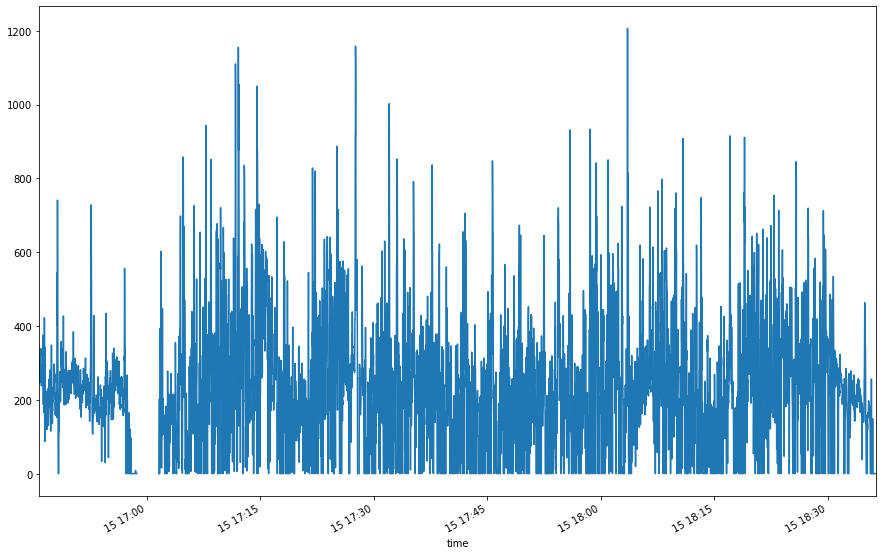

In [14]:
df['power'].plot(figsize=(15, 10))

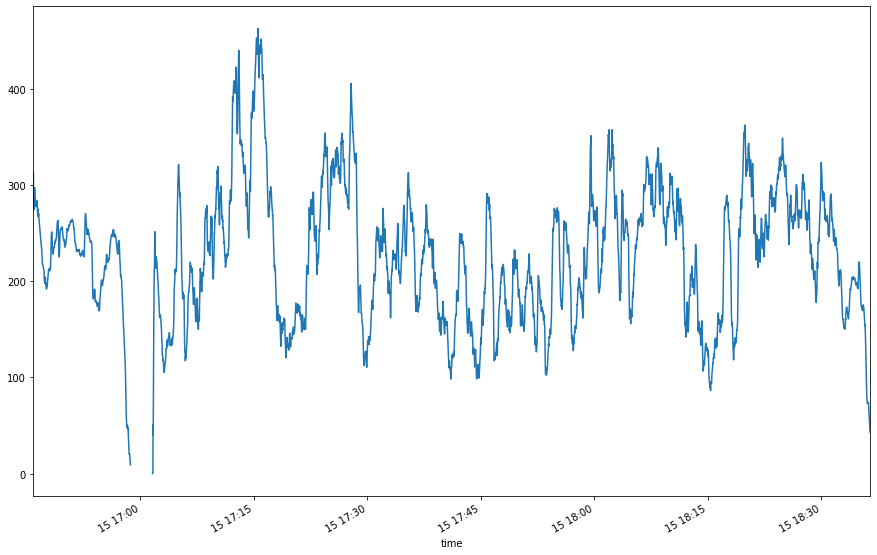

In [15]:
# Plot the 60 second rolling average power
df['power'].rolling('60s').mean().plot(figsize=(15, 10))

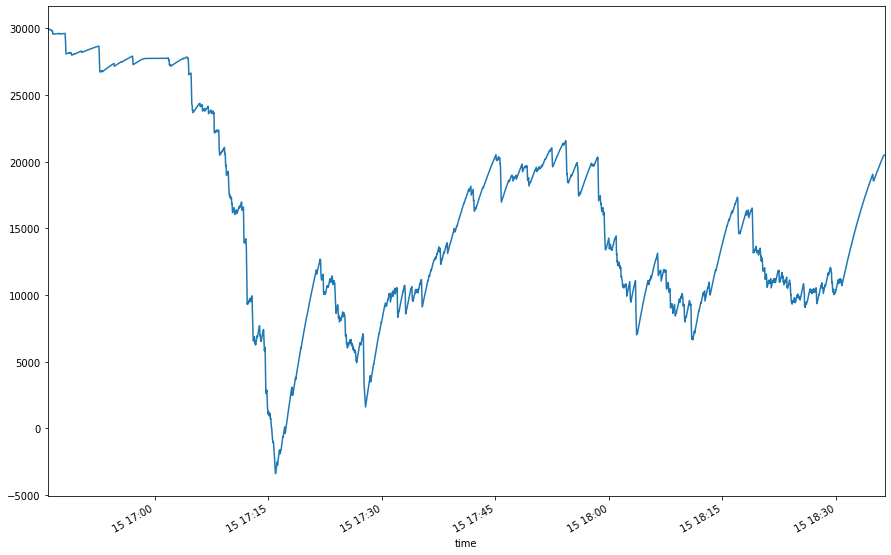

In [16]:
df['w_prime'].plot(figsize=(15, 10))

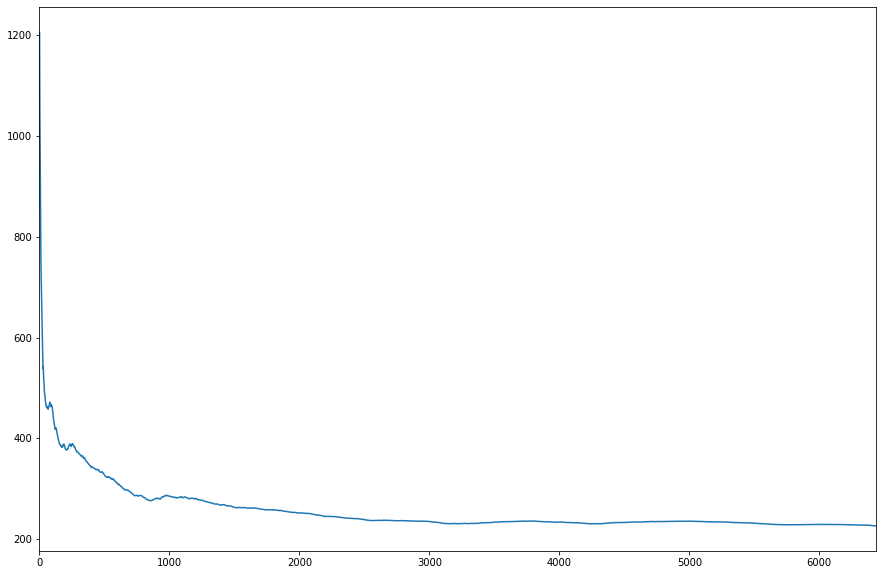

In [17]:
mmp.plot(figsize=(15,10))